In [1]:
import os

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from rdquantum.hamiltonian import Rydberg_Cz

In [2]:
# Define Hamiltonian
H = Rydberg_Cz()

In [3]:
# Create environment
env = gym.make('rdquantum/HamiltonianTrainer-v2023.04.22', Hamiltonian=Rydberg_Cz)
observation, info = env.reset()
# print(observation, info)

In [4]:
# Hyperparameters
algo = 'PPO'
B = 30 # batch_size
EPOCHS = 50
eval_interval = 1
lr = 1e-2 # 1e-2 for SGD
policy_steps = 20

log_prob_clip = 5
grad_clip = 0.001
importance_ratio_eps = 0.2
value_loss_coeff = 0.5

optimizer = tf.optimizers.Adam(learning_rate=lr)

In [5]:
# rootdir = r'.'
r_amp = H.r_amp
r_gate_time = H.r_gate_time
# print(r_amp, r_gate_time)


# trainable variables
actions = ['omega_p_amp', 'omega_r_amp', 'delta_p_amp', 'gate_time']
mean = {s : tf.Variable(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32), name='mean_'+s) for s in actions}
sigma = {s : tf.Variable(0.5, name='sigma_'+s) for s in actions}
baseline = tf.Variable(0.0, name='baseline')

In [6]:
test_action = {
    'omega_p_amp': [100/H.r_amp],
    'omega_r_amp': [175/H.r_amp],
    'delta_p_amp': [400/H.r_amp],
    'gate_time': [1.0/H.r_gate_time]
}

In [7]:
def reward_sampler(a, _type):
    # print('a: ', a, '\n')
    rewards = []
    
    for i in range(B):
        a_np = {s : np.array(a[s][i] if _type=='collection' else [a[s]]) for s in actions}
        # print('a_np: ', a_np, '\n')
        observation, reward, terminated, truncated, info = env.step(a_np)
        rewards.append(reward)

    return tf.cast(rewards, tf.float32)

In [8]:
def compute_log_prob(a, mean, sigma):
    sigma_eps = 1e-5 # for mumerical stability
    log_prob = 0.
    for s in a.keys():
        log_prob += - tf.math.log(tf.math.abs(sigma[s]) + sigma_eps) \
            - 0.5 * (a[s] - mean[s])**2 / (sigma[s]**2 + sigma_eps)
    return log_prob

In [9]:
def action_sampler(actions, sample_batch = 1):
    N = {s : tfp.distributions.TruncatedNormal(loc=mean[s], scale=sigma[s], low=0, high=1) for s in actions}
    a = {s : N[s].sample(B) for s in actions}
    return a

In [10]:
train_samples = 0
train_rewards = []
for epoch in range(1,EPOCHS+1):

    train_samples += B
    # print('train_samples:', train_samples)

    # sample a batch of actions from Gaussian policy
    a = action_sampler(actions, sample_batch=B)

    # collect those rewards
    R =  reward_sampler(a, 'collection')
    # print('rewards: ', R)

    # log prob according to old policy (required for importance ratio)
    if epoch == 1: mean_old, sigma_old = mean, sigma
    log_prob_old = compute_log_prob(a, mean_old, sigma_old)
    log_prob_old = tf.clip_by_value(log_prob_old, -log_prob_clip, log_prob_clip)
    mean_old = tf.nest.map_structure(tf.identity, mean)
    sigma_old = tf.nest.map_structure(tf.identity, sigma)
    
    # calculate policy loss and do several gradient updates
    for i in range(policy_steps):
        with tf.GradientTape(persistent=True) as tape:
            # log prob according to the current policy
            log_prob = compute_log_prob(a, mean, sigma)
            log_prob = tf.clip_by_value(log_prob, -log_prob_clip, log_prob_clip)

            A = R - baseline # action advantages

            if algo == 'REINFORCE':
                policy_loss_batch = - A * log_prob

            if algo == 'PPO':
                importance_ratio = tf.math.exp(log_prob - log_prob_old)
                importance_ratio_clip = tf.clip_by_value(importance_ratio, 
                            1-importance_ratio_eps, 1+importance_ratio_eps)
                policy_loss_batch = -tf.minimum(importance_ratio*A, importance_ratio_clip*A)

            policy_loss = tf.reduce_mean(policy_loss_batch) # reduce over batch
            value_loss = tf.reduce_mean(A**2)
            loss = policy_loss + value_loss_coeff * value_loss
            # print(loss)

            grads = tape.gradient(loss, tape.watched_variables())
            grads = tf.clip_by_value(grads, -grad_clip, grad_clip)
            optimizer.apply_gradients(zip(grads, tape.watched_variables()))
            
    print('Epoch %d: ' %(epoch), R)
    train_rewards.append(np.array(R))
    # log['train_actions'].append(np.array(a['theta']))
    # log['train_epochs'].append(epoch)
    # log['train_samples'].append(train_samples)
    # if epoch % eval_interval == 0: evaluation(epoch, log)

run_params = dict(B = B, EPOCHS = EPOCHS, eval_interval = eval_interval,
        lr = lr, policy_steps = policy_steps, log_prob_clip = log_prob_clip,
        grad_clip = grad_clip, importance_ratio_eps = importance_ratio_eps,
        value_loss_coeff = value_loss_coeff)            

Epoch 1:  tf.Tensor(
[ 1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1.], shape=(30,), dtype=float32)
Epoch 2:  tf.Tensor(
[ 1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.
  1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.], shape=(30,), dtype=float32)
Epoch 3:  tf.Tensor(
[-1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1. -1.], shape=(30,), dtype=float32)
Epoch 4:  tf.Tensor(
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.
  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.], shape=(30,), dtype=float32)
Epoch 5:  tf.Tensor(
[-1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1.
  1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1.  1.], shape=(30,), dtype=float32)
Epoch 6:  tf.Tensor(
[-1.  1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1.  1.  1. -1.  1. -1. -1.  1. 

In [11]:
R

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([ 1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,
       -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,
        1.,  1., -1., -1.], dtype=float32)>

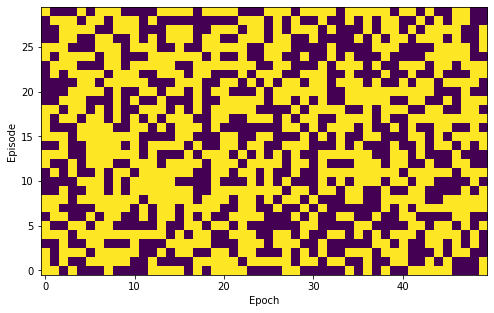

In [12]:
result = np.array(train_rewards)
plt.matshow(np.reshape(result, (EPOCHS, B)).transpose())
plt.xlabel("Epoch")
plt.ylabel("Episode")
plt.gca().invert_yaxis()
plt.gca().tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
# plt.colorbar()